# Principal Components Analysis

> COM2004/COM3004

*Copyright &copy; 2022 University of Sheffield. All rights reserved*.

## Objective

In this notebook you will use Principal Components Analysis to produce a compact representation of the letter image data. You will demonstrate that this compact representation provides a basis for robust letter classification.

## Background

In the previous exercises you performed dimensionality reduction using simple feature selection. Using a combination of brute force and ingenuity you found it was possible to select individual pixel features that allowed robust classification with feature vectors with only 10 elements. In this notebook you will perform a similar degree of dimensionality reduction but this time using a technique called Principal Components Analysis (PCA). PCA constructs features that are the linear combination of the original feature values that best preserves the spread of the data. It will produce good performance without the need for a complex feature selection algorithm.

## 1. Overview of key functions

These exercises will use two functions that we have used in previous notebooks.

* `divergence` - for measuring 1-D divergence
* `classify` - a nearest neighbour classifier

For convenience, code for these functions is re-included in this notebook.

## 2. Loading the data

The data is stored in a pickle file called `lab_data_wk7.pkl`. We will load this data using the `pickle.load` function that we saw in the last notebook. The data is similar to that used last time except that there are now two separate test sets.

In [1]:
import pickle
import numpy as np

lab_data = pickle.load(open("data/lab_data_wk7.pkl", "rb"))
train_labels = lab_data["train_labels"]
test_labels = lab_data["test_labels"]
test2_labels = lab_data["test2_labels"]
train_data = lab_data["train_data"]
test_data = lab_data["test_data"]
test2_data = lab_data["test2_data"]

Similarly to in the last notebook, the matrices `train_data`, `test_data` and `test2_data` contain 699, 200 and 200 feature vectors respectively stored in a matrix form. Each row represents one feature vector and contains the 900 pixel values for one character.

Remember, you can view the *i*th character in the training set by typing,

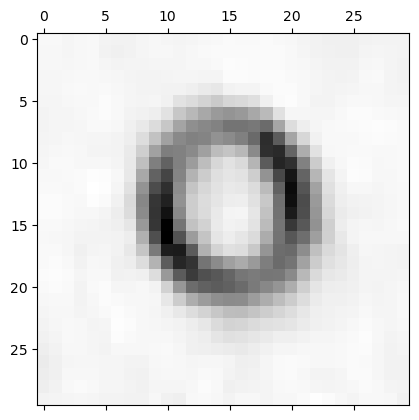

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

letter_image = np.reshape(train_data[0, :], (30, 30), order="F")
plt.matshow(letter_image, cmap=cm.Greys_r)

The vectors `train_labels`, `test_labels` and `test2_labels` store the character labels as integers using a code where 1=A, 2=B, 3=C. Try displaying some other characters.

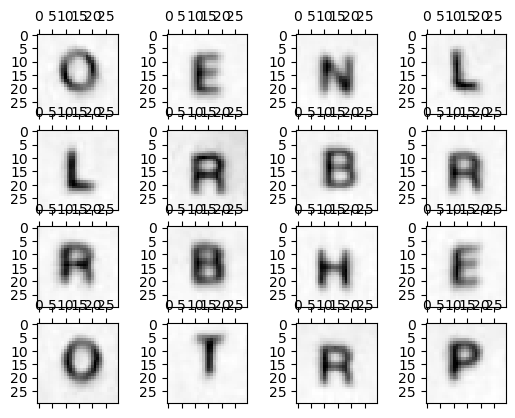

In [5]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

nmax = 16
for i in range(nmax):
    axis = plt.subplot(4, 4, i + 1)
    letter_image = np.reshape(train_data[i, :], (30, 30), order="F")
    axis.matshow(letter_image, cmap=cm.Greys_r)

## 3. Principal Component Analysis – a primer

As you have seen, the letter images in your training and test sets are represented by 900-dimensional feature vectors. Hence, any particular letter image can be pictured as a single point in a 900-d space. The complete training set is therefore a collection of 699 points in 900-d space, i.e., the training data forms a small cluster in 900-d space. Now, this cluster will be more spread about its centre in some directions than in others. The PCA technique simply identifies a set of orthogonal directions in which the amount of spread (i.e., the variance) is the greatest, i.e., consider first finding the one direction in which the spread is greatest; then find a direction in which the spread is greatest but which is also at right-angles to the first direction found; then find a direction in which the spread is greatest while also being at right angle to the first two directions; and so on. (Remember that in 900-d space there can be 900 mutually perpendicular directions.) These directions – ordered in terms of spread -- will be known as the principal component axes.

**How does finding the principal components allow us to perform dimensionality reduction?**

Well, once the first few principal components have been found we can measure the distance of a point from the cluster center (i.e., the distance from the mean point) along these few directions, e.g., perhaps 10 directions. Now we can represent the 900-d point by these 10 measurements. Measuring the point positions along these directions is known as ‘projecting onto the principal component axes’. Crucially, because the directions are ordered by the size of the spread in that direction, the position along the first, say 10, principal components axes will approximate the position of the point in 900-d space, i.e., the distances from the mean in the other 890 orthogonal directions will be smaller and less important. This projection step is simple to compute, it is actually just a linear transform of the 900-d vector, $x$, i.e., $y = A x$.

There is another way of thinking about the principal components. Each axis direction can be represented as a 900-d vector. This vector itself could be visualized as a 30 by 30 image, i.e., each principal component is now being conceptualized as an image (a 'basis image’) rather than as an axis. Recall that when we projected onto the principal component axes we were taking a 900-d feature vector and describing its position relative to the centre of the cluster as a sum of movements along the principal component axes directions. In the alternative view, this is equivalent to describing the original image as being formed by an average image plus a weighted sum of the basis images, i.e., the position of the point along each principal component axes is telling us by how much to weight the corresponding basis image in the sum. We can approximate every image in the training and test set as the weighted sum of a small number of basis images.

All of the above would not be very interesting if it was not possible to actually compute the principal components. Fortunately it turns out that the principal components are easy to compute: they are the 'eigenvectors' of the data’s covariance matrix. This might sound complicated, but it is just a few lines of Python.

*Do not worry if you did not completely follow all of the above. Reread it at the end and ask for help if you are still confused.*

## 4. Computing the Principal Components

The principal components are simply the eigenvectors of the covariance matrix. They can be computed using the training data with just two lines of Python code. For example, to compute the first 40 principal components use the following,

In [6]:
import scipy.linalg

covx = np.cov(train_data, rowvar=0)
N = covx.shape[0]
w, v = scipy.linalg.eigh(covx, eigvals=(N - 40, N - 1))
v = np.fliplr(v)
v.shape

C:\Users\po_ya\AppData\Local\Temp\ipykernel_27608\2792388037.py:5: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  w, v = scipy.linalg.eigh(covx, eigvals=(N - 40, N - 1))


(900, 40)

The function `eigh` will return the eigenvectors (i.e., principal component axes) as column vectors in the matrix `V`. Check the sizes of `covx` and `V` by using `print(covx.shape)` and `print(v.shape)`. Make sure that you understand why these matrices have the sizes that they have.

You can view the principal components as basis images ('eigenletters' ?) by reshaping them into a 30 by 30 matrix. Look at the first four,

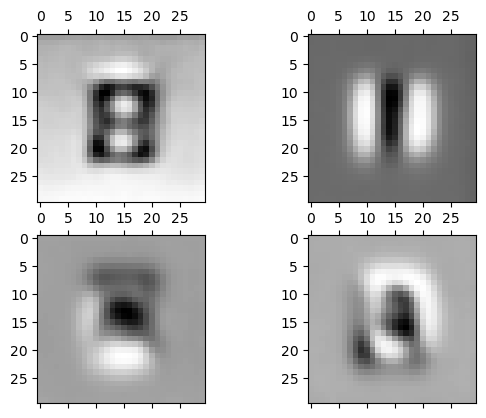

In [7]:
axis = plt.subplot(2, 2, 1)
axis.matshow(np.reshape(v[:, 0], (30, 30), order="F"), cmap=cm.Greys_r)
axis = plt.subplot(2, 2, 2)
axis.matshow(np.reshape(v[:, 1], (30, 30), order="F"), cmap=cm.Greys_r)
axis = plt.subplot(2, 2, 3)
axis.matshow(np.reshape(v[:, 2], (30, 30), order="F"), cmap=cm.Greys_r)
axis = plt.subplot(2, 2, 4)
axis.matshow(np.reshape(v[:, 3], (30, 30), order="F"), cmap=cm.Greys_r)

PCA will represent the original letter data as a weighted sum of these eigenletter images. Loosely speaking, they are like the common components from which the set of letter images are 'built'.

## 5. Projecting the data onto the principal component axes ##

We will now perform the actual dimensionality reduction by projecting the 900 dimensional images onto the first 40 principal components, i.e., we will perform the linear transform, $y=Vx$ (actually, because our images are stored as row vectors and our principal components as column vectors, the equation looks like y = x V; don’t let this confuse you).

Also, it is best to 'centre' the data before transforming it by subtracting the mean letter vector. So we have:

In [8]:
pcatrain_data = np.dot((train_data - np.mean(train_data)), v)
pcatest_data = np.dot((test_data - np.mean(train_data)), v)
pcatest2_data = np.dot((test2_data - np.mean(train_data)), v)

Note, numpy is using 'broadcasting' so that the single mean vector is being subtracted from every row of the training or test data matrices in one go, without needing a loop.

Because we have only used the first 40 principal components some information has been lost. But because the principal component are ordered by the amount of variance that they capture, the amount of information lost will be minimized. (Note, the word ‘information’ is being used in a rather wooly way here, but the above statement is true in a more technical sense as long as certain assumptions can be made about the distribution of the data. These details need not overly concern us.)

To see how closely the original image can be reconstructed we can project back from the 40-d space to the original 900 dimension. After projecting back we should remember to undo the centering by adding back the mean vector. This can be done simply by,

In [9]:
reconstructed = np.dot(pcatrain_data, v.transpose()) + np.mean(train_data)
print(reconstructed)

[[604.60844467 603.55156191 602.88552432 ... 600.26577696 602.8465575
  602.20034692]
 [536.01530937 536.44943532 536.12322046 ... 535.38582665 536.6717311
  536.46242856]
 [509.00835436 511.30314328 511.76341696 ... 519.56084626 519.88386584
  519.00927373]
 ...
 [520.13392492 520.85726315 520.41386196 ... 521.47418443 523.6654063
  524.07654698]
 [550.90593959 549.38767245 548.37435412 ... 546.55833446 548.56185678
  548.73559824]
 [519.82765425 522.08376934 521.95994849 ... 515.42209795 513.72133532
  513.52608838]]


We can now display one of the reconstructed characters and compare it to the original,

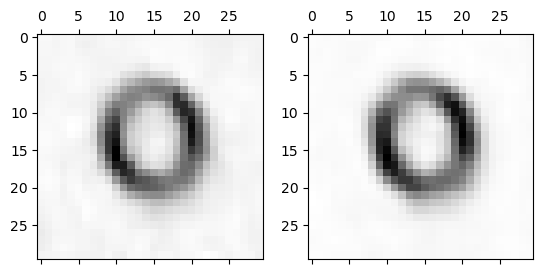

In [10]:
axis = plt.subplot(1, 2, 1)
axis.matshow(np.reshape(train_data[0, :], (30, 30), order="F"), cmap=cm.Greys_r)
axis = plt.subplot(1, 2, 2)
axis.matshow(np.reshape(reconstructed[0, :], (30, 30), order="F"), cmap=cm.Greys_r)

You should see that the reconstructed letter looks very similar to the original. Notice how, because only 40 PCA components have been used rather than all 900, the image is somewhat 'smoothed’. This is a good thing – the largely irrelevant noise component has been effectively removed.

To project just the first image from the training data set into $N$-dimensional PCA space and back again we can use:

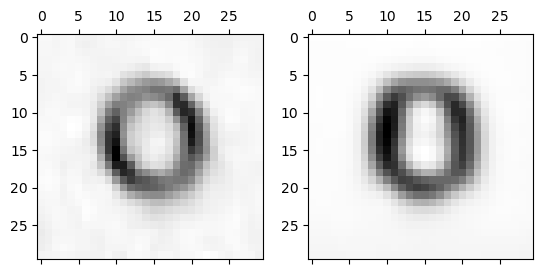

In [11]:
N = 6
mean_train = np.mean(train_data, axis=0)
reconstructed = (
    np.dot(
        np.dot(train_data[0, :] - mean_train, v[:, 0 : N - 1]),
        v[:, 0 : N - 1].transpose(),
    )
    + mean_train
)
axis = plt.subplot(1, 2, 1)
axis.matshow(np.reshape(train_data[0, :], (30, 30), order="F"), cmap=cm.Greys_r)
axis = plt.subplot(1, 2, 2)
axis.matshow(np.reshape(reconstructed, (30, 30), order="F"), cmap=cm.Greys_r)

Experiment with different values of $N$. The figure below shows an example using the letter 'O' in train_data(1,:) with N equal to 1, 2, 3, 4, 5 and 6. Notice how the 'O'ness of the ‘O’ is captured by just the first 4 principal components! Experiment with different letters. For example, how many components are needed to capture the essential quality of an 'A'?

![PCA-ed Ohs](graphics/Ohs.png)

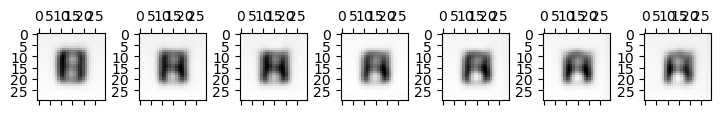

In [12]:
nmax = 8  # number of pca components
sample_index = 5  # index of sample to reconstruct

train_example = train_data[sample_index, :]
mean_train = np.mean(train_data, axis=0)

plt.figure(figsize=(10,3))
plt.tight_layout()
plt.subplots_adjust(wspace =0.5, hspace =0)
for n in range(1, nmax):
    npca = n * 2
    reconstructed = (
        np.dot(
            np.dot(train_example - mean_train, v[:, 0:npca]), v[:, 0:npca].transpose()
        )
        + mean_train
    )
    axis = plt.subplot(1, nmax, n + 1)
    axis.matshow(np.reshape(reconstructed, (30, 30), order="F"), cmap=cm.Greys_r)

## 6. Performing the classification

We can now test our nearest neightbour classifier on the PCA’ed data. Here is the code for the classifier again:

In [13]:
def classify(train, train_labels, test, test_labels, features=None):
    """Perform nearest neighbour classification."""

    # Use all feature is no feature parameter has been supplied
    if features is None:
        features = np.arange(0, train.shape[1])

    # Select the desired features from the training and test data
    train = train[:, features]
    test = test[:, features]

    # Super compact implementation of nearest neighbour
    x = np.dot(test, train.transpose())
    modtest = np.sqrt(np.sum(test * test, axis=1))
    modtrain = np.sqrt(np.sum(train * train, axis=1))
    dist = x / np.outer(modtest, modtrain.transpose())  # cosine distance
    nearest = np.argmax(dist, axis=1)
    mdist = np.max(dist, axis=1)
    label = train_labels[0, nearest]
    score = (100.0 * sum(test_labels[0, :] == label)) / label.shape[0]

    # Construct a confusion matrix
    nclasses = np.max(np.hstack((test_labels, train_labels)))
    confusions = np.zeros((nclasses, nclasses))
    for i in range(test_labels.shape[1]):
        confusions[test_labels[0, i] - 1, label[i] - 1] += 1

    return score, confusions

We will first test it using 40 PCA features.

In [14]:
score, cm = classify(pcatrain_data, train_labels, pcatest_data, test_labels, range(40))
print(score)

85.0


Now try with just 10.

In [15]:
score, cm = classify(pcatrain_data, train_labels, pcatest_data, test_labels, range(10))
print(score)

79.0


Results may seem a little disappointing, probably about 85% and 79%. This is not so high compared with the figures in the 90’s that could be achieved with feature selection. But now try classifying again but this time using PCA components 2 to 11:

    classify(pcatrain_data, train_labels, pcatest_data, test_labels, range(1, 11))

 Try this in the cell below.

In [16]:
score, cm = classify(
    pcatrain_data, train_labels, pcatest2_data, test2_labels, range(1, 11)
)
print(score)

94.0


Classification performance when using features 2 to 11 should be considerably better than when using features 1 to 10 (try and think why.). Performance should now be comparable to the best results that were achieved in the last notebook. But note, these results have been achieved with considerably less fuss. For example, there was no trial and error or brute force search. PCA just worked. It will work equally well for many similar problems and for larger and more difficult data sets.

## 7. Feature Selection

Typically, with PCA, we would take the first $N$ PCA components as our features. However, let us try combining PCA and the feature selection ideas from last notebook. Starting with the 40 principal components that you have computed can you find the 10 that give best performance?

You could try using trial and error or you could try reusing the divergence code from last notebook where you will now being computing the 1-D divergences for the PCA features. Remember, you will need some way of summing divergences over pairs of classes. The simplest approach would be to rank the PCA features according to their 1-D divergence and simply pick the best 10, i.e., assuming that the 10-D divergence can be estimated as the sum of the 10 1-D divergences. (In the previous lab, when we used pixel data as the features, we saw that this simple summing was not a good approach. However, summing 1-D divergences is more valid when using PCA features than when using raw pixel feaatures. Why?)

Test your feature selection on the `test2` dataset. Can you score higher than the highest score that we achieved by applying feature selection directly to pixel features?

[ 1  8  6  5 11 12 27 15  2]
92.5


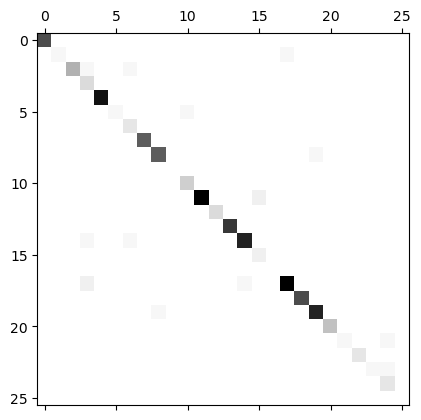

In [17]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def divergence(class1, class2):
    """compute a vector of 1-D divergences
    
    class1 - data matrix for class 1, each row is a sample
    class2 - data matrix for class 2
    
    returns: d12 - a vector of 1-D divergence scores
    """

    # Compute the mean and variance of each feature vector element
    m1 = np.mean(class1, axis=0)
    m2 = np.mean(class2, axis=0)
    v1 = np.var(class1, axis=0)
    v2 = np.var(class2, axis=0)

    # Plug mean and variances into the formula for 1-D divergence.
    # (Note that / and * are being used to compute multiple 1-D
    #  divergences without the need for a loop)
    d12 = 0.5 * (v1 / v2 + v2 / v1 - 2) + 0.5 * (m1 - m2) * (m1 - m2) * (
        1.0 / v1 + 1.0 / v2
    )

    return d12

# SOLUTION
d = 0
for char1 in np.arange(1, 24):
    char1_data = pcatrain_data[train_labels[0, :] == char1, :]
    for char2 in np.arange(char1+1, 24):
        char2_data = pcatrain_data[train_labels[0, :] == char2, :]
        d12 = divergence(char1_data, char2_data)
        d = d + d12
        sorted_indexes = np.argsort(-d)
        features = sorted_indexes[0:9]
        
print(features)
score, confusions = classify(pcatrain_data, train_labels, pcatest2_data, test2_labels, features)
print(score)
plt.matshow(confusions, cmap=cm.Greys)

## 8. Robustness to noise

Try adding Gaussian noise to the 900-dimensional test data, (i.e., generate gaussianly-distributed random numbers using numpy.random.normal). Now, transform the noisy data into the PCA domain and rerun the classifier. Compare the noise robustness of the original 900-d feature vectors and the 10-d PCA based features. Which of these feature vectors can tolerate the greatest amount of added noise in the test data? Why do you think this is?

In [18]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

size = test2_data.shape  # Size of the noise array
# Generate Gaussian noise
noise = np.random.normal(0, 1, size)
reconstructed_test2 = test2_data + noise
    
score, confusions = classify(pcatrain_data, train_labels, test2_data, test2_labels)
print(score)

6.0


6.0


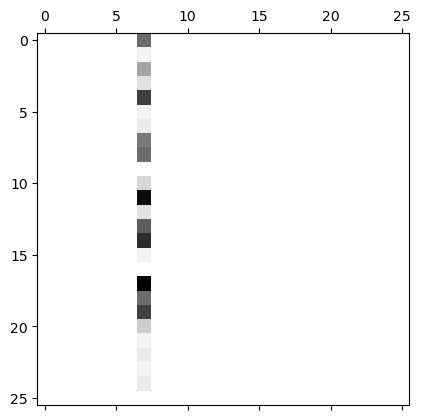

In [19]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#for sample_index in range(0,24):
    #test_example = test2_data[sample_index, :]

mean_test = np.mean(test2_data, axis=0)
npca = 16

reconstructed_test2 = (
    np.dot(
        np.dot(test2_data[:, :] - mean_test, v[:, 0:npca]), v[:, 0:npca].transpose()
    )
    + mean_test
)

noise = np.random.normal(0, 1, (200,900))

reconstructed_test2 = reconstructed_test2 + noise

pcatest2_data = np.dot((reconstructed_test2 - np.mean(train_data)), v)
score, confusions = classify(pcatrain_data, train_labels, reconstructed_test2, test2_labels)
print(score)
plt.matshow(confusions, cmap=cm.Greys)